<h1><center>Fast Food Marketing Campaign</center></h1>
<center>May 2024</center>
<center>Celine Ng</center>

<a id="0"></a> <br>
# Table of Contents

1. [Project Introduction](#1)     
    1. [Libraries Installation](#2) 
    1. [Data Retrieval](#3)
    1. [Data Cleaning](#4)
1. [EDA](#5) 
    1. [Quick Visualization](#6)
        1. [Summary](#7)
    1. [Separate by Promotion](#8)
        1. [Summary](#9)
1. [Target Metrics](#10) 
1. [Calculations](#11)
    1. [Statistical Test](#12)
1. [Create a Validation Set](#4)     
    1. [Remove target column](#5) 
1. [Feature Scaling](#6)     
1. [First Model](#8)     
    1. [Evaluation Metrics for Training set](#9)     
    1. [Evaluation Metrics for Validation set](#10)     
    1. [First Submission](#11) 
1. [Selecting Models](#12)       
    1. [Helper Functions to Try New Models](#13)      
    1. [Split to the Small Data for Evaluating Models Fast](#14)     
    1. [ML Models](#15)         
        1. [XGBoost](#16)             
            1. [Training](#17)


<a id="1"></a> <br>
# 1. Project Introduction

### Goal
The fast-food chain tested out 3 promotions in several store and <br>
the data records sales in the initial 4 weeks of the new promotion. <br>
Apply A/B test to understand which of the 3 campaigns is the most effective.

<a id="2"></a> <br>
## 1.1 Libraries Installation

In [186]:
%%capture
%pip install -r requirements.txt

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.plotting import *
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
import scipy.stats as stats
from utils.statistics import * 

<a id="3"></a> <br>
## 1.2 Data Retrieval

In [188]:
fastfood = pd.read_csv('dataset/fast_food.csv')

In [189]:
fastfood.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


<a id="4"></a> <br>
## 1.3 Data Cleaning

1. Check for missing values

In [190]:
fastfood.isna().any().any()

False

2. Check for duplicates 

In [191]:
fastfood.duplicated().any()

False

<a id="5"></a> <br>
# 2. EDA

<a id="6"></a> <br>
## 2.1 Quick Visualization

Objective:
Briefly understand our data and its distribution

1. Rows and columns of our dataset

In [192]:
fastfood.shape

(548, 7)

2. Dataset descriptive statistics overview

In [193]:
fastfood.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


3. How many MarketID and LocationID?

In [194]:
fastfood['MarketID'].nunique()

10

In [195]:
fastfood['LocationID'].nunique()

137

4. Visualize dataset features

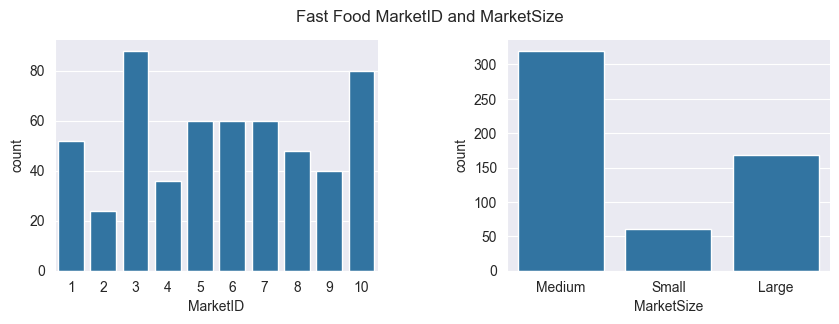

In [196]:
columns_to_plot = [col for col in fastfood.columns if col in ['MarketID', 
                                                              'MarketSize']]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
fig.subplots_adjust(hspace=0.3, wspace=0.4)

for i, col in enumerate(columns_to_plot):
    sns.countplot(x=col, data=fastfood, ax=ax[i])

sns.despine(top=True, right=True, left=False, bottom=False)

fig.suptitle('Fast Food MarketID and MarketSize')

plt.show()

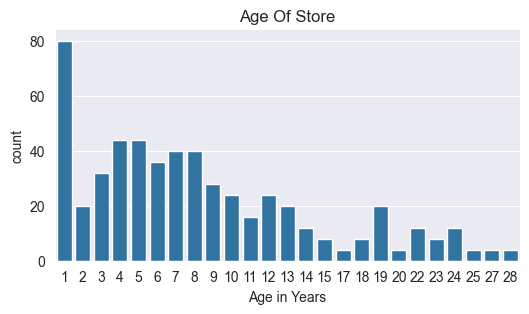

In [197]:
plt.figure(figsize=(6, 3))
sns.countplot(x='AgeOfStore', data=fastfood)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Age in Years')
plt.title('Age Of Store')
plt.show()

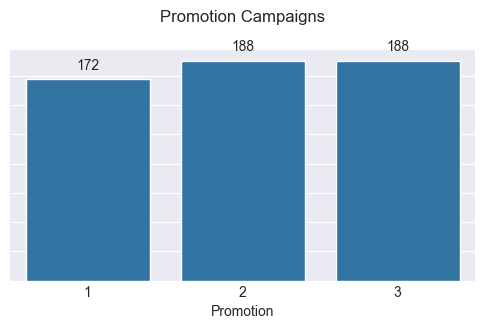

In [198]:
plt.figure(figsize=(6, 3))
ax = sns.countplot(x='Promotion', data=fastfood)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p
                                           .get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset'
                                                                     ' points')
    
sns.despine(top=True, right=True, left=True, bottom=True)
ax.tick_params(axis='x', which='both', length=0, labelbottom=True)
ax.tick_params(axis='y', which='both', length=0, labelleft=False)
ax.set(ylabel=None)

plt.title('Promotion Campaigns', pad=20)
plt.show()

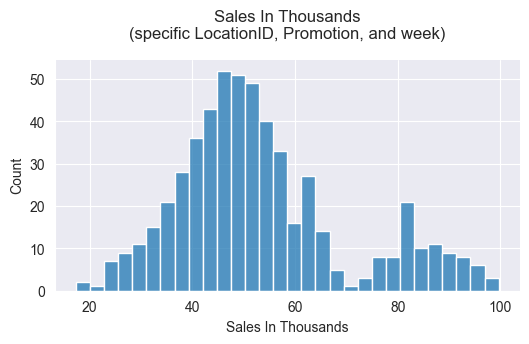

In [199]:
plt.figure(figsize=(6, 3))
sns.histplot(data=fastfood, x='SalesInThousands', bins=30, kde_kws={'shade':
                                                                        True})
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Sales In Thousands')
plt.title('Sales In Thousands\n(specific LocationID, Promotion, and week)', 
          pad=15)
plt.show()

<a id="7"></a> <br>
## 2.1.1 Summary

Our dataset is composed by sales data of the 3 promotions, registered across
 <br>
10 unique markets and 137 store locations. <br>
Our sample shows that most markets are medium, with 50% of stores are less <br>
than 7 years old. Median sales are around 50 000 and all 3 promotion <br>
campaigns were tested similar amounts of times, with 172 for promotion 1 and
 <br>
 188 for promotions 2 and 3. Most likely, promotion 1 was tested in less <br>
 store location. 
 
*To note: Both SalesInThousands and AgeOfStore distributions seem to be <br>
bimodal, which likely indicate 2 different sub-populations in our data.*

<a id="8"></a> <br>
## 2.2 Separate by Promotion

Objective: <br>
To better define our target metric and properly pick the correct statistical
 <br>
tests, it is essential to first understand the features, and the 
relationship <br> between them, specially with the 3 promotions. <br> 

1. How many stores were attributed to each promotion?

In [200]:
fastfood.groupby(['Promotion'])['LocationID'].nunique()

Promotion
1    43
2    47
3    47
Name: LocationID, dtype: int64

There are 43 locations for Promotion 1 and 47 locations for Promotion 2 and 
<br>
3, since each location tested the campaigns for 4 weeks, this is also the <br>
number of SalesInThousands registered per promotion per week.

2. How do the features vary with difference Promotions?

In [201]:
promotion_details = fastfood.groupby(['Promotion']).describe()

**Market ID**

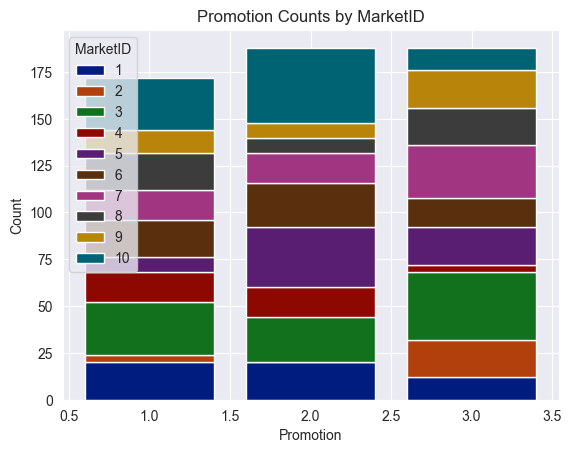

In [202]:
stacked_bar_plot(fastfood, col='Promotion', hue='MarketID')

**Market Size**

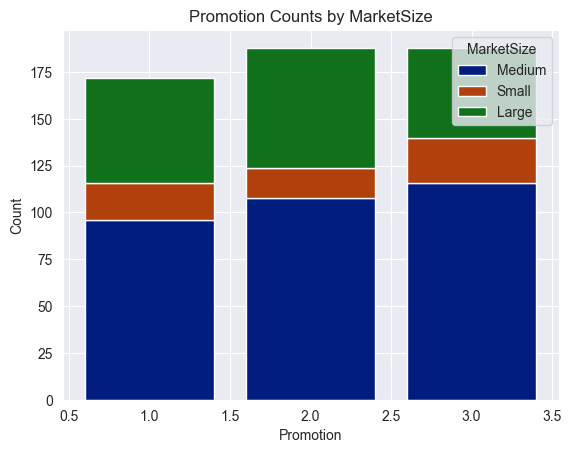

In [203]:
stacked_bar_plot(fastfood, col='Promotion', hue='MarketSize')

**Age of Store**

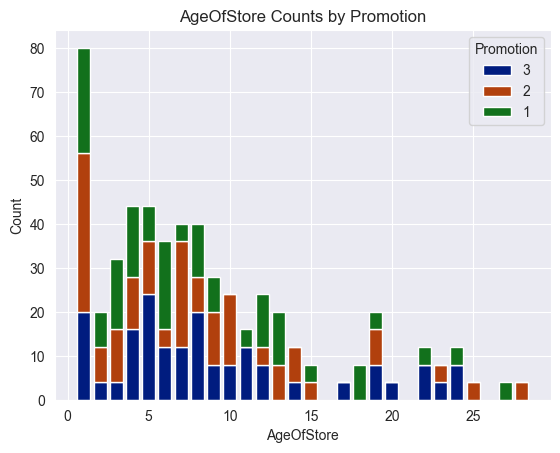

In [204]:
stacked_bar_plot(fastfood, col='AgeOfStore', hue='Promotion')

In [205]:
promotion_details.AgeOfStore

,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,8.279070,6.636160,1.0,3.0,6.0,12.0,27.0
2,188.0,7.978723,6.597648,1.0,3.0,7.0,10.0,28.0
3,188.0,9.234043,6.651646,1.0,5.0,8.0,12.0,24.0


Promotion 2 has the youngest mean and smallest standard deviation of stores. <br>
In general, the promotion samples are quite equally and randomly distributed
 <br>
 considering their MarketID, MarketSize and AgeOfStore.

**Sales In Thousands**

In [206]:
fastfood.groupby(['Promotion']).describe()

MarketID                                               LocationID  \
             count      mean       std  min  25%  50%  75%   max      count   
Promotion                                                                     
1            172.0  5.790698  2.993624  1.0  3.0  6.0  8.0  10.0      172.0   
2            188.0  5.893617  2.897419  1.0  4.0  6.0  9.0  10.0      188.0   
3            188.0  5.468085  2.742816  1.0  3.0  6.0  8.0  10.0      188.0   

                       ...  week      SalesInThousands                        \
                 mean  ...   75%  max            count       mean        std   
Promotion              ...                                                     
1          488.465116  ...  3.25  4.0            172.0  58.099012  16.553782   
2          497.446809  ...  3.25  4.0            188.0  47.329415  15.108955   
3          453.808511  ...  3.25  4.0            188.0  55.364468  16.766231   

                                                   
             min      25%     50%      75%    max  
Promotion                                          
1          30.81  46.3525  55.385  63.6175  99.65  
2          17.34  38.1700  45.385  51.7450  88.64  
3          22.18  44.1975  51.165  61.7325  96.48  

[3 rows x 40 columns]

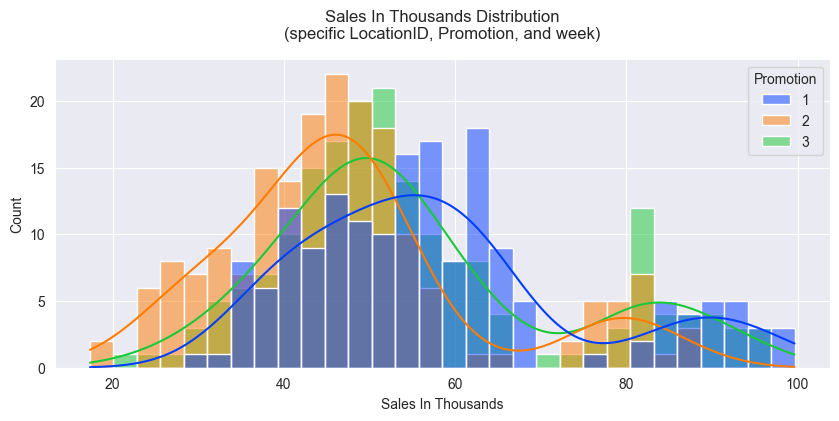

In [207]:
plt.figure(figsize=(10, 4))
sns.histplot(data=fastfood, x='SalesInThousands', hue='Promotion', bins=30,
             palette=sns.color_palette('bright', n_colors=3), kde=True)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Sales In Thousands')
plt.title('Sales In Thousands Distribution\n(specific LocationID, Promotion, '
          'and week)', pad=15)
plt.show()

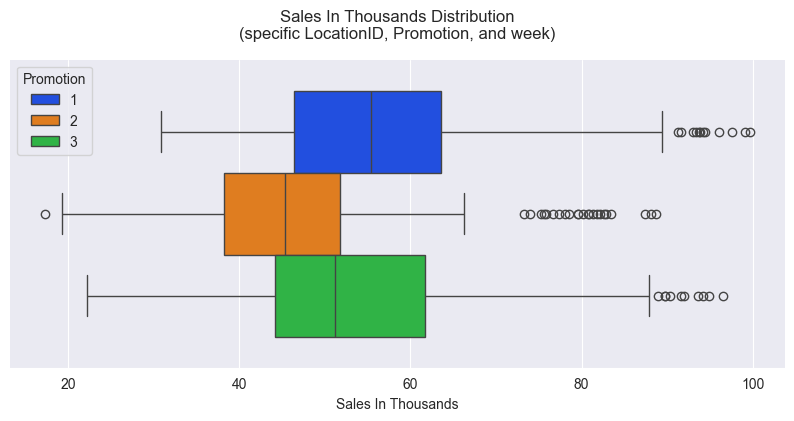

In [208]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=fastfood, x='SalesInThousands', hue='Promotion',
             palette=sns.color_palette('bright', n_colors=3))
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xlabel('Sales In Thousands')
plt.title('Sales In Thousands Distribution\n(specific LocationID, Promotion, '
          'and week)', pad=15)
plt.show()

In [209]:
promotion_details.SalesInThousands

,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,58.099012,16.553782,30.81,46.3525,55.385,63.6175,99.65
2,188.0,47.329415,15.108955,17.34,38.1700,45.385,51.7450,88.64
3,188.0,55.364468,16.766231,22.18,44.1975,51.165,61.7325,96.48


The distribution of Sales of all 3 Promotions are bimodal and they <br>
differ in their mean and variance. <br>
Promotion 2 has the lowest mean and median, with also the lowest standard <br>
deviation and IQR. While Promotion 1 seems to have the highest sales, it also
 <br>
 has the highest variability, less defined peaks. 

**Sales In Thousands per Week**

3. Plot Sales In Thousands by week to check if bimodal distribution is 
caused by differences of sales in different weeks.

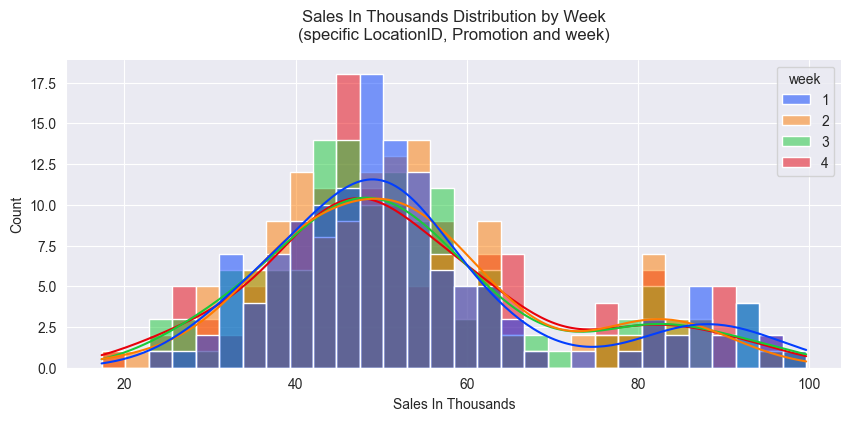

In [210]:
plt.figure(figsize=(10, 4))
sns.histplot(data=fastfood, x='SalesInThousands', hue='week', bins=30,
             palette=sns.color_palette('bright', n_colors=4), kde=True)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Sales In Thousands')
plt.title('Sales In Thousands Distribution by Week\n(specific LocationID, '
          'Promotion and week)', pad=15)
plt.show()

Sales distribution is still bimodal in different weeks, so this is not the 
cause.

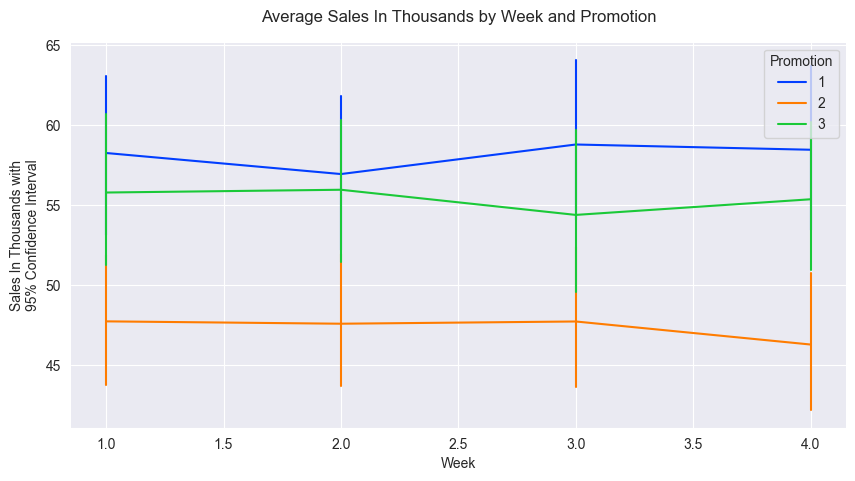

In [211]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=fastfood, x='week', y='SalesInThousands', hue='Promotion',
             palette=sns.color_palette('bright', n_colors=3), err_style='bars',
             errorbar=('ci', 95))
sns.despine(top=True, right=True, left=True, bottom=False)
plt.xlabel('Week')
plt.ylabel('Sales In Thousands with\n95% Confidence Interval')
plt.title('Average Sales In Thousands by Week and Promotion', pad=15)
plt.show()

In [212]:
promotion_week_details = fastfood.groupby(['week', 'Promotion']).describe()
promotion_week_details.SalesInThousands

count       mean        std    min     25%    50%     75%  \
week Promotion                                                              
1    1           43.0  58.244419  16.798929  35.30  48.740  53.79  62.245   
     2           47.0  47.730213  14.387406  27.81  38.965  46.02  50.645   
     3           47.0  55.776170  18.071909  24.75  45.850  51.01  59.705   
2    1           43.0  56.929535  16.553088  35.86  42.635  55.11  62.855   
     2           47.0  47.582553  14.854098  17.34  38.885  45.75  52.050   
     3           47.0  55.949149  15.643490  22.18  48.495  53.47  61.215   
3    1           43.0  58.774884  16.423121  32.05  48.030  56.19  64.090   
     2           47.0  47.722128  15.979831  23.93  37.395  45.35  52.540   
     3           47.0  54.377872  17.219269  29.03  43.120  50.55  61.565   
4    1           43.0  58.447209  16.962984  30.81  47.005  56.84  64.500   
     2           47.0  46.282766  15.604704  19.26  36.625  44.84  52.190   
     3           47.0  55.354681  16.535599  26.68  44.815  50.05  63.155   

                  max  
week Promotion         
1    1          99.65  
     2          88.64  
     3          96.48  
2    1          96.01  
     2          82.86  
     3          90.30  
3    1          99.12  
     2          88.12  
     3          93.63  
4    1          97.61  
     2          80.75  
     3          94.21

Values for Promotion 1 and 3 might not have a true significant difference
<br>
due to their overlapping confidence intervals and larger standard deviations.
<br>
<br>
*The 95% confidence interval automatically generated by Seaborn Lineplot 
uses <br>
the bootstrapping method.* <br>

<a id="9"></a> <br>
## 2.2.1 Summary

1. There are 43 locations for Promotion 1 and 47 locations for Promotion 2 
and 3.
2. Per week by promotion, there are 43 registers for Promotion 1 and 47 for 
<br> Promotion 2 and 3.
3. The data sample for each promotion are randomly distributed across Market <br>
ID, Market Sizes and Age of Store. Therefor, all represent a similar target 
<br>
population.
4. Sales In Thousands distribution by promotion are all bimodal, each with a
 <br>
 visual difference in mean and variance.
5. Average values for Sales In Thousands vary slightly through the weeks for
 <br>
all promotions, with Promotion 2 registering the least sales and Promotion 1
 <br>
the highest during the whole time. <br>
*Important: Values for Promotions 1 and 3 are close and their 
<br>confidence intervals overlap for all 4 weeks.*

<a id="10"></a> <br>
# 3. Target Metrics

After looking at the data from different perspectives, the amount of Sales <br>
itself show a good difference between Promotions, and only slight <br>
difference in the Sales growth in time. <br> 

**Target Metric** <br>
Average Sales by Promotion: Identify which of the 3 promotions has the 
highest <br> average sales 

<a id="11"></a> <br>
# 4. Calculations
Objectives: <br>
1. Decide on the best suited statistical tests for our target metric.
2. Conduct statistical tests.
3. Report confidence interval and p-value. <br>
Compute confidence interval analytically and using boostrap.

To compare means of Promotion 1, 2 and 3, to minimize type 1 error, ANOVA <br>
test is used to detect if there is any difference between the 3 groups. Then
 <br>
 for post-hoc test, Tukey HSD will find out which specific groups' means <br>
 differ. <br>
 For all the statistical tests, the significance level we are interested in 
 <br>
 is 0.05.

<a id="12"></a> <br>
## 4.1 Statistical Tests

**Assumption Checking** <br>
1. Promotions 1, 2 and 3 are independent and shown to be randomly sampled.
2. Sample sizes for the promotions are (172, 188, 188). Even the data itself
 <br>
 was not normally distributed, because ANOVA will be comparing the means of 
 <br>
the groups and our sample sizes are large, Central Limit Theorem supports <br>
the assumption that the distribution of the means will be normal.
3. Equal variances across groups will be checked with Levene's Test.

In [213]:
stat, p_value = levene(fastfood[fastfood['Promotion'] == 1]['SalesInThousands'],
                       fastfood[fastfood['Promotion'] == 2]['SalesInThousands'],
                       fastfood[fastfood['Promotion'] == 3]['SalesInThousands'])

print("Levene's Test Statistic:", stat, "P-value:", p_value)

Levene's Test Statistic: 1.2696787527507418 P-value: 0.2817514565692093


p-value > 0.05, so variance are homogeneous. <br>
Let's proceed with the ANOVA test.

### ANOVA Test

**Null Hypothesis (H0):**<br>
There is no difference in the SalesInThousands average between the 3 <br> 
Promotions. Suggesting that the mean sales are the same for each promotional
 <br>strategy. <br>

**Alternative Hypothesis (H1):**<br>
At least one of the promotions have a different average SalesInThousands <br>
than others. Implying that at least one of the promotional strategy had a <br>
statistically significant difference in terms of sales. 

In [214]:
model = ols('SalesInThousands ~ C(Promotion)', data=fastfood).fit()
anova_results = sm.stats.anova_lm(model, typ=1)
print(anova_results)

                 df         sum_sq      mean_sq          F        PR(>F)
C(Promotion)    2.0   11449.174291  5724.587145  21.953486  6.765849e-10
Residual      545.0  142114.105414   260.759826        NaN           NaN


With p-value way below our significance level (0.05), we can reject the null
 <br>
 hypothesis, this strongly suggests that there is a statistically 
 significant <br>
 difference between the sales mean of the groups.

### PostHoc - Tukey HSD

**Null Hypothesis (H0):**<br>
There is no significant difference between the average sales between the 2 
<br>
compared promotions.
<br> 

**Alternative Hypothesis (H1):**<br>
There is a significant difference between the average sales between the 2 
<br>
compared promotions.

In [215]:
print(pairwise_tukeyhsd(fastfood['SalesInThousands'], fastfood['Promotion'], 
                        alpha=0.05))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2 -10.7696    0.0 -14.7738 -6.7654   True
     1      3  -2.7345 0.2444  -6.7388  1.2697  False
     2      3   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


Promotion 1 and 3 had a mean difference of -2.7345, p-value of 0.244 (larger
 <br>
 than 0.05), and its confidence interval contains 0. So, we fail to reject 
 the <br>
 null hypothesis, as the test does not indicate statistical significance <br>
 between the 2 promotions. <br>
 
However, Promotion 2 is statistically different with both Promotions 1 and 3.

## 4.2 Confidence Interval

**Analytical Approach - Estimating Population Mean with Confidence**

In [216]:
ci_results = [ci_mean_analytical(data=fastfood[fastfood['Promotion'] == i]
['SalesInThousands']) for i in range(1, 4)]

ci_df = pd.DataFrame(ci_results, columns=['Mean', 'CI Lower', 'CI Upper'])
ci_df['Promotion'] = ['Promotion 1', 'Promotion 2', 'Promotion 3']
ci_df = ci_df[['Promotion', 'Mean', 'CI Lower', 'CI Upper']]
ci_df

,Promotion,Mean,CI Lower,CI Upper
0,Promotion 1,58.099012,55.607485,60.590539
1,Promotion 2,47.329415,45.155596,49.503234
2,Promotion 3,55.364468,52.952207,57.776730


**Bootstrapping Approach**

In [217]:
ci_bootstrap(data=fastfood.groupby(['Promotion']).SalesInThousands)

TypeError: ci_bootstrap() missing 2 required positional arguments: 'groupby' and 'col'

<a id="7"></a> <br>
# 3. Assumptions Checking

Objective:
Simple random sample <br>
Large enough sample to approximate our sampling distribution with a normal <br>
curve (to use z multiplier...) <br>
define large enough as at least ten of each response outcomes <br>

Target Metric:
Average Sales by Promotion (but how about that bimodal distribution) (large 
enough to apply CLT)
Growth from week 1 to week 4 by Promotion (assume random sample) (large 
enough to apply CLT)


# Improvements

1. Average might not represent the data the best, due to its bimodal nature.
2. Find the underlying cause of bimodal distribution and then split the
data before further analysis.